In [1]:
import sys
sys.path.append("../")
from libraries.dataManipulation import *
from libraries.gridManipulation import *
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import random
import warnings
warnings.filterwarnings(action='ignore')
import time

In [2]:
from sociophysicsDataHandler import SociophysicsDataHandler

In [3]:
def convert_to_unixtimestamp(datetime_utc):
    return (datetime_utc - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [4]:
#Check for train
#TODO
def check_train(timestamp):
    train_present = False

In [5]:
#Spawn people
def spawn_people(timestamp):
    global current_ID
    if timestamp in people_in_dictionary_off:
        spawn_zones = people_in_dictionary_off[timestamp]
        for zone in spawn_zones:
            offboarding_people_locs[current_ID] = zone
            simulation_list.append([current_ID,True,False,timestamp,zone])
            current_ID += 1
    
    if timestamp in people_in_dictionary_on:
        spawn_zones = people_in_dictionary_on[timestamp]
        for zone in spawn_zones:
            onboarding_people_locs[current_ID] = zone
            simulation_list.append([current_ID,False,True,timestamp,zone])
            current_ID += 1

In [6]:
#Determine the density based on the locations of people
def calculate_density():
    locs = {**onboarding_people_locs,**offboarding_people_locs}
    
    #Create empty density dictionary
    density = {} #Dictionary with zone IDs as keys and density as values
    #Set all densities to 0
    for i in range(n_zones+1):
        density[i-1] = 0
    
    #Cycle through all the people in the locs dictionary
    for i in locs.keys():
        density[locs[i]] += 1
        
    return density

In [7]:
#Get a new zone for a person a markov matrix and a randomly generated number
def get_new_zone(current_zone, markov_matrix):

    #Get the probabilities for the zone and apply the randomness
    probabilities = markov_matrix.iloc[current_zone].to_numpy()
    i = 0 #Iterator to keep track of which column/movement must be selected
    if (sum(probabilities) == 0):
        rand  = 0
    else:
        rand = random.random() * sum(probabilities)
        
    while rand > probabilities[i]:
        rand -= probabilities[i]
        i += 1

    #Get the new zone based on the movement (column of markov matrix) that is selected
    return i
    

In [8]:
#Function to relate density to probability adjustment
def density_probability(density):
    #Example function
    return (-density) / 10000

In [9]:
#Adjust the probabilities of moving between zones according to density in neighbouring zones
#TODO
def adjust_markov_matrix(matrix_input, density):
    matrix = matrix_input.copy()
    for i in range(n_zones):
        matrix[i] = matrix[i] + density_probability(density[i])
    
    matrix[matrix<0] = 0

    return matrix

In [10]:
#Change the position of people according to the corresponding markov matrix
def move():
    global simulation_list
    
    #Loop through offboarders with markov matrix adjusted for density
    markov_matrix = adjust_markov_matrix(markov_matrix_offboarding, density)
    
    for offboarder_ID in offboarding_people_locs.keys():
        
        current_zone = offboarding_people_locs[offboarder_ID]
        
        new_zone = get_new_zone(current_zone, markov_matrix)
        
        offboarding_people_locs[offboarder_ID] = new_zone
        simulation_list.append([offboarder_ID,True,False,time,new_zone])
    
    #Loop through onboarders with markov matrix adjusted for density and whether there is a train
    if train_present:
        markov_matrix = adjust_markov_matrix(markov_matrix_onboarding_train, density)
    else:
        markov_matrix = adjust_markov_matrix(markov_matrix_onboarding_no_train, density)
        
    for onboarder_ID in onboarding_people_locs.keys():
        
        current_zone = onboarding_people_locs[onboarder_ID]
        
        new_zone = get_new_zone(current_zone, markov_matrix)

        onboarding_people_locs[onboarder_ID] = new_zone
        simulation_list.append([onboarder_ID,False,True,time,new_zone])
         

In [11]:
%%time

#Initialize variables
start_date_time = pd.to_datetime('2020-04-20T12:00:00') #Starting time of simulation
time = convert_to_unixtimestamp(start_date_time)
sim_duration = 3600 #How long the simulation lasts in seconds

train_present = False

#Number of zones
zone_rows = 4
zone_columns = 18
n_zones = zone_rows * zone_columns

#Variables that have to be determined in different steps
markov_matrix_offboarding = pd.read_csv('test_markov_matrix.csv', header=None)
markov_matrix_onboarding_no_train =  pd.read_csv('test_markov_matrix.csv', header=None)
markov_matrix_onboarding_train =  pd.read_csv('test_markov_matrix.csv',header=None)
density_influence_table = None
people_in_dictionary_off = {time:[50,51,55,57,59,60]}
people_in_dictionary_on = {time:[2,4,6,8,10,12]}

#Information about people
current_ID = 1000 #People will also have an ID in the simulation, only a different one
offboarding_people_locs = {} #Dictionary with person IDs as keys and zone IDs as values
onboarding_people_locs = {} #Dictionary with person IDs as keys and zone IDs as values
density = {} #Dictionary with zone IDs as keys and density as values
#Set all densities to 0
for i in range(n_zones+1):
    density[i-1] = 0
    
#Create dataframe to store the data over time
simulation_list = list()

# SIMULATE 

#Start looping
for i in range(sim_duration):
    
    check_train(time)
    
    move()
    
    spawn_people(time)
    
    density = calculate_density()
    
    time += 1

simulation_df = pd.DataFrame(simulation_list, columns = ['ID','Offboarding','Onboarding','Time','Zone'])
simulation_df['x_pos'] = simulation_df['Zone'].divide(zone_rows).apply(np.floor)
simulation_df['y_pos'] = (simulation_df['Zone']).mod(zone_rows)
simulation_df.head()

Wall time: 1min 36s


ID  Offboarding  Onboarding        Time  Zone  x_pos  y_pos
0  1000         True       False  1587384000    50   12.0      2
1  1001         True       False  1587384000    51   12.0      3
2  1002         True       False  1587384000    55   13.0      3
3  1003         True       False  1587384000    57   14.0      1
4  1004         True       False  1587384000    59   14.0      3

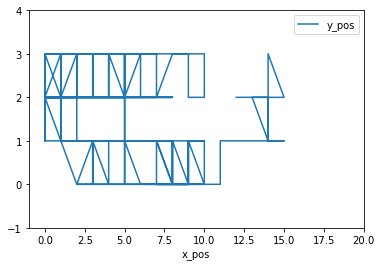

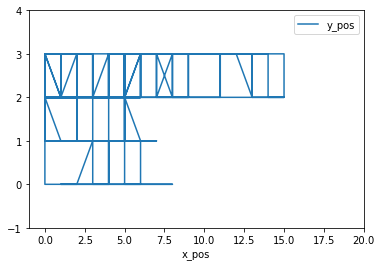

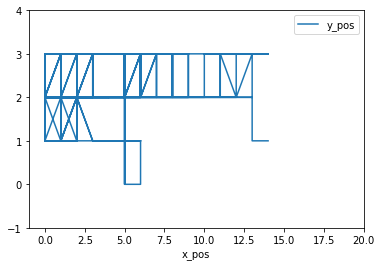

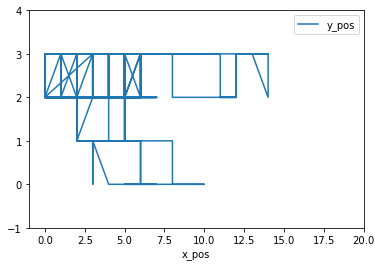

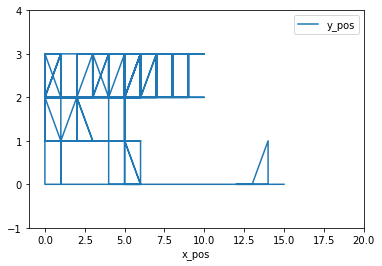

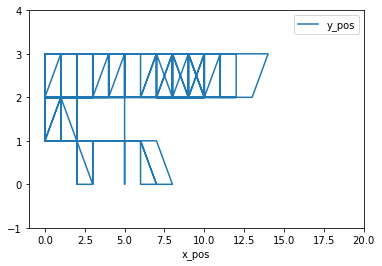

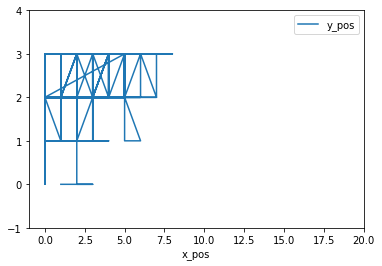

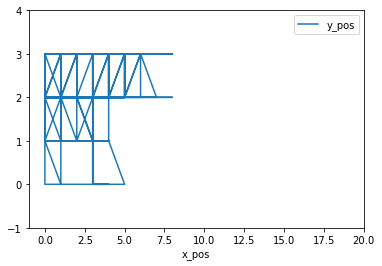

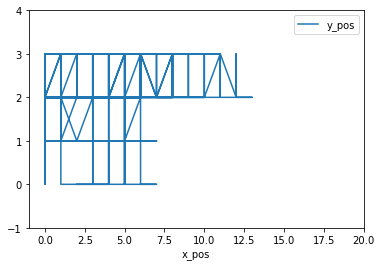

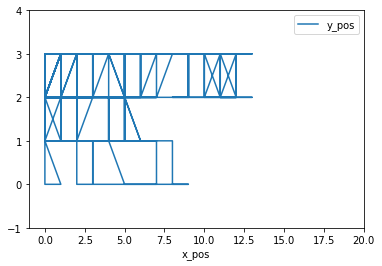

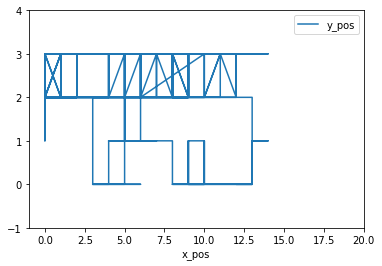

In [12]:
ax = simulation_df.groupby('ID').plot('x_pos','y_pos', xlim = [-1, 20], ylim = [-1,4]);

In [15]:
markov_matrix_offboarding.head()

0         1         2             3         4         5   \
0  8.057785e-01  0.090315  0.000000  3.380206e-05  0.099959  0.003849   
1  1.997319e-02  0.782889  0.073849  0.000000e+00  0.005705  0.102435   
2  2.690756e-05  0.005019  0.924716  3.395239e-02  0.000033  0.000395   
3  1.776214e-08  0.000169  0.039012  9.419305e-01  0.000000  0.000000   
4  1.937691e-02  0.004667  0.000000  4.268193e-08  0.841813  0.039221   

         6         7             8             9   ...        62        63  \
0  0.000000  0.000000  2.631418e-05  9.398496e-06  ...  0.000000  0.000000   
1  0.014998  0.000000  1.552871e-05  4.745786e-06  ...  0.000008  0.000006   
2  0.031547  0.003529  6.382994e-08  1.668577e-05  ...  0.000003  0.000002   
3  0.000840  0.018023  0.000000e+00  1.776214e-08  ...  0.000000  0.000000   
4  0.000000  0.000000  9.070768e-02  4.069523e-03  ...  0.000000  0.000000   

    64   65   66   67   68   69   70   71  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 72 columns]